# 2- Texture Synthesis
in this question we want to synthesis a pattern from a texture
we have some obstacles we should face with it :
1) how to choose pattern from our texture (with which standards?)

2) how to find best boundary cut (dynamic) , in a way that our pattern looks natural and perfect!

in the following we discussed about each above problems .

to make a pattern from a texture , first we make a empty matrice with arbitrary size(base on your opinion) and then for first template , we choose a random section from a texture.

after that we choose overlap (right overlap) with desired size (i choose a overlap with height of 100 and width of 20, note that by experiment , i understand that the bigger overlap's width , the better result we get ) . so the overlap we choose is our template , we have to find a template in our texture with best matching. in this part we use `cv2.matchTemplate(texture,overlap)` .

after finding proper match , we have to find best patch ( best boundary cut) .
to reach best boundary cut we use dynamic programming (minimum cost).

* note that each pixel just access to its neighbor's pixel(just a square around it with size of 3). this point is important in giving scores to each pixel

to implement this algorithm , i defined two additional matrices , `matrix_index` and `matrix_score` .
`matrix_index` : for each pixels in overlap region , have a value that show which if it's neighbor lead to minimum cost in each level .

`matrix_score` : for each pixels in overlap region , have a value that show it's minimum cost in each level .

for example if a pixel have a value of 1 in `matrix_index` and have a value of 34 in `matrix_score` it means that if we go from the pixel to it's neighbor ,'1' (have 3 neighbors named form '0' to '2') we have minimum cost and it's cost is 34.

after that, we define two functions , `find_path_vertical` and `find_path_horizontal ` and with help of `matrix_index` and `matrix_scores` we find minimum-cost path .
below you can see the functions  :

In [1]:
# verical find patch

def find_path_vertical(overlap):
    [c1, c2] = np.array(overlap).shape

    matrix1_score = np.zeros([c1, c2])
    matrix1_score[0, :] = overlap[0, :]

    matrix_index = np.zeros([c1, c2])

    for x in range(1, c1):
        for y in range(0, c2):
            num1, num2, num3 = np.ones([3, 1])*100000000
            num2 = overlap[x, y]+matrix1_score[x-1, y]
            if(y-1 >= 0):
                num1 = overlap[x, y]+matrix1_score[x-1, y-1]

            if(y+1 < c2):
                num3 = overlap[x, y]+matrix1_score[x-1, y+1]

            array_temp = [num1, num2, num3]
            index = (np.where(array_temp == np.min(array_temp)))
            matrix_index[x, y] = index[0][0]
            matrix1_score[x, y] = np.min(array_temp)

    temp = np.where(np.min(matrix1_score[c1-1, :]) == matrix1_score)
    end_pos = temp[1][0]

    x_r = np.zeros([c1])
    x_r[0] = 0

    y_r = np.zeros([c1])
    y_r[c1-1] = end_pos


    for x in range(c1-1, 0, -1):

        x_r[x] = x


        if(matrix_index[x, int(y_r[x])] == 0):
            y_r[x-1] = y_r[x]-1

        if(matrix_index[x, int(y_r[x])] == 1):
            y_r[x-1] = y_r[x]

        if(matrix_index[x, int(y_r[x])] == 2):
            y_r[x-1] = y_r[x]+1

    return x_r, y_r

# -----------------------------------
# ------------------------------------
# horizental find patch

def find_path_horizental(overlap):
    [c1, c2] = np.array(overlap).shape

    matrix1_score = np.zeros([c1, c2])
    matrix1_score[:, 0] = overlap[:, 0]

    matrix_index = np.zeros([c1, c2])

    for y in range(1, c2):
        for x in range(0, c1):
            num1, num2, num3 = np.ones([3, 1])*100000000
            num2 = overlap[x, y]+matrix1_score[x, y-1]
            if(x-1 >= 0):
                num1 = overlap[x, y]+matrix1_score[x-1, y-1]

            if(x+1 < c1):
                num3 = overlap[x, y]+matrix1_score[x+1, y-1]

            array_temp = [num1, num2, num3]
            index = (np.where(array_temp == np.min(array_temp)))
            matrix_index[x, y] = index[0][0]
            matrix1_score[x, y] = np.min(array_temp)

    temp = np.where(np.min(matrix1_score[:, c2-1]) == matrix1_score)
    end_pos = temp[0][0]

    y_r = np.zeros([c2])
    y_r[0] = 0

    x_r = np.zeros([c2])
    x_r[c2-1] = end_pos

    for x in range(c2-1, 0, -1):

        y_r[x] = x

        if(matrix_index[int(x_r[x]), x] == 0):
            x_r[x-1] = x_r[x]-1

        if(matrix_index[int(x_r[x]), x] == 1):
            x_r[x-1] = x_r[x]

        if(matrix_index[int(x_r[x]), x] == 2):
            x_r[x-1] = x_r[x]+1

    return x_r, y_r


after making  first row and first column, we face a new challenge . we have 2 overlaps with intersection .


for that we have to find :
1) best template match

2) find boundary cut for them

to find best template match , we use `cv2.matchTemplate` twice. so we get 2 score matrix for two different template matching .
one for left_overlap and second one for top_overlap . then we resize two score matrices and sum these together . at the end we find the maximum score in merged matrix . these algorithm lead to find the best coordinates that satisfy both overlaps .also we don't have to worry about the point of intersection . we just fill the pixels before the cut_boarder with original image and let the other pixels to be from template texture .


## structure of code
in the section below you can set wich texture to synthes by changing the address of image `texture = cv2.imread('wall.jpg')` :

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from numpy.core.fromnumeric import size


# ----------------------------------- read texture

texture = cv2.imread('wall.jpg')
texture = cv2.cvtColor(texture, cv2.COLOR_BGR2RGB)
texture = np.array(texture)
[c1, c2, c3] = texture.shape

gray_texture = np.array(cv2.cvtColor(
    texture[:c1-100, :c2-100, :], cv2.COLOR_RGB2GRAY))


synthesis_image = np.zeros([2500, 2500, c3])

parameter = int(2500//100)


# size of texture to be sampled is 100*50
# ----- choose a random sample :
x_r = random.randrange(0, c1-100)
y_r = random.randrange(0, c2-100)
sample = texture[x_r:x_r+100, y_r:y_r+100, :]

synthesis_image[0:100*(1), 0:100*(1), :] = sample



## final code

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
<ipython-input-1-5f1be325f944>:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  index = (np.where(array_temp == np.min(array_temp)))
<ipython-input-1-5f1be325f944>:75: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you mus

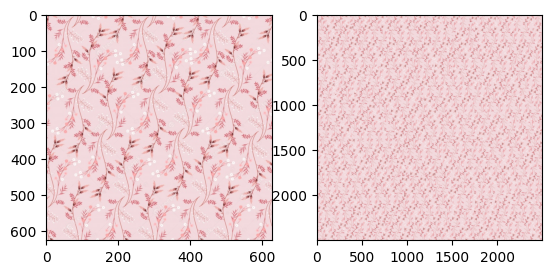

In [3]:
# ------------------------------------first horizental level
for yy in range(1, int(parameter)):

    [g1, g2, g3] = (np.array(sample)).shape

    portion = sample[:, g2-20:g2, :]
    gray_portion = np.array(cv2.cvtColor(portion, cv2.COLOR_RGB2GRAY))

    scores = cv2.matchTemplate(
        gray_texture, gray_portion, cv2.TM_CCOEFF_NORMED)

    for treshhold in np.arange(1, 0, -0.02):
        ff = np.where(scores >= treshhold)
        number_of_candidates = (size(ff[1]))
        if(number_of_candidates >= 1):
            break
    num1 = random.randint(0, int(number_of_candidates)-1)

    sample_n = texture[ff[0][num1]:ff[0][num1] +
                       100, ff[1][num1]:ff[1][num1]+120, :]

    synthesis_image[100*(0):100*(1), 100*(yy)-20:100*(yy)+100, :] = sample_n

    gray_sample = cv2.cvtColor(sample, cv2.COLOR_RGB2GRAY)
    gray_sample_n = cv2.cvtColor(sample_n, cv2.COLOR_RGB2GRAY)

    overlap = (gray_sample[:, g2-20:g2]-gray_sample_n[:, 0:20])**2

    x, y = find_path_vertical(overlap)

    c1 = np.size(x)

    for x in range(0, 100):
        synthesis_image[x, int(100*yy -
                        20):int(y[x]+100*yy-20)+1, :] = sample[x, int(g2-20):int(y[x]+g2-20)+1, :]
        synthesis_image[x, int(y[x]+100*yy -
                        20)+1:, :] = synthesis_image[x, int(y[x]+100*yy-20)+1:, :]

    sample = sample_n


# --------------------------------------

sample = np.copy(synthesis_image[0:100, 0:100, :])

# --------------------------------------first vertical level
for yy in range(1, int(parameter)):

    [g1, g2, g3] = np.array(sample).shape

    portion = sample[g1-20:g1, :, :]
    gray_portion = np.array(cv2.cvtColor(
        portion.astype('uint8'), cv2.COLOR_RGB2GRAY))

    scores = cv2.matchTemplate(
        gray_texture, gray_portion, cv2.TM_CCOEFF_NORMED)

    for treshhold in np.arange(1, 0, -0.02):
        ff = np.where(scores >= treshhold)
        number_of_candidates = (size(ff[1]))
        if(number_of_candidates >= 1):
            break
    num1 = random.randint(0, int(number_of_candidates)-1)

    sample_n = texture[ff[0][num1]:ff[0][num1] +
                       120, ff[1][num1]:ff[1][num1]+100, :]

    synthesis_image[100*(yy)-20:100*(yy)+100, 100*(0):100*(1), :] = sample_n

    gray_sample = cv2.cvtColor(sample.astype('uint8'), cv2.COLOR_RGB2GRAY)
    gray_sample_n = cv2.cvtColor(sample_n.astype('uint8'), cv2.COLOR_RGB2GRAY)

    overlap = (gray_sample[g1-20:g1, :]-gray_sample_n[0:20, :])**2

    x, y = find_path_horizental(overlap)

    c1 = np.size(x)

    for xx in range(0, 100):
        # print(x[xx], 'xxx')
        synthesis_image[int(100*yy -
                        20):int(x[xx]+100*yy-20+1), xx, :] = sample[int(g1-20):int(x[xx]+g1-20)+1, xx, :]
        synthesis_image[int(x[xx]+100*yy -
                        20)+1:, xx, :] = synthesis_image[int(x[xx]+100*yy-20)+1:, xx, :]

    sample = sample_n

    # ------------------------------------------ other stages
parameter = int(2500//100)

for k1 in range(1, parameter):


    for k2 in range(1, parameter):

        synthesis_image_copy = np.copy(synthesis_image)

        # ---------------------------------------------

        portion1 = np.copy(
            synthesis_image_copy[k1*100-20:(k1)*100, k2*100-20:(k2+1)*100, :])  # upper overlap
        gray_portion1 = np.array(cv2.cvtColor(
            portion1.astype('uint8'), cv2.COLOR_RGB2GRAY))


        scores1 = cv2.matchTemplate(
            gray_texture, gray_portion1, cv2.TM_CCOEFF_NORMED)

        # --------------------------------------------

        portion2 = np.copy(
            synthesis_image_copy[k1*100-20:(k1+1)*100, k2*100-20:(k2)*100, :])  # left overlap
        gray_portion2 = np.array(cv2.cvtColor(
            portion2.astype('uint8'), cv2.COLOR_RGB2GRAY))

        scores2 = cv2.matchTemplate(
            gray_texture, gray_portion2, cv2.TM_CCOEFF_NORMED)
        # -------------------------------------------------
        [c1, c2] = np.array(scores1).shape
        [c11, c22] = np.array(scores2).shape
        height = min(int(c1), int(c11))
        width = min(int(c2), int(c22))
        scores_total = np.zeros([height, width])
        scores_total = scores1[0:height, 0:width]+scores2[0:height, 0:width]


        for treshhold in np.arange(1, 0, -0.02):
            ff = np.where(scores_total >= treshhold)
            number_of_candidates1 = (size(ff[1]))
            if(number_of_candidates1 >= 1):
                break
        num11 = random.randint(0, int(number_of_candidates1)-1)


        sample_n = texture[ff[0][num11]:ff[0][num11] +
                           120, ff[1][num11]:ff[1][num11]+120, :]

        synthesis_image[k1*100-20:(k1+1)*100, k2 *
                        100-20:+(k2+1)*100, :] = sample_n


        # --------------------upper overlap
        gray_sample1 = cv2.cvtColor(
            portion1.astype('uint8'), cv2.COLOR_RGB2GRAY)
        gray_sample_n1 = cv2.cvtColor(
            sample_n[0:20, :, :].astype('uint8'), cv2.COLOR_RGB2GRAY)

        overlap1 = (gray_sample1-gray_sample_n1)**2
        x_u, y_u = find_path_horizental(overlap1)

        # ------------------- left overlap
        gray_sample2 = cv2.cvtColor(
            portion2.astype('uint8'), cv2.COLOR_RGB2GRAY)
        gray_sample_n2 = cv2.cvtColor(
            sample_n[:, 0:20, :].astype('uint8'), cv2.COLOR_RGB2GRAY)

        overlap2 = (gray_sample2-gray_sample_n2)**2
        x_l, y_l = find_path_vertical(overlap2)

        # ---------------------

        counter1 = np.size(x_u)

        counter2 = np.size(x_l)

        min_dis = 100000000

        x_final = 0
        y_final = 0

        for g in range(0, int(counter1)):
            for h in range(0, int(counter2)):

                temporary = np.sqrt((x_u[g]-x_l[h])**2+(y_u[g]-y_l[h])**2)

                if(temporary <= min_dis):
                    min_dis = temporary
                    x_final = max(x_u[g], x_l[h])
                    y_final = max(y_u[g], y_l[h])



        for xx in range(0, 120):


            synthesis_image[int(k1*100-20):int(k1*100-20+x_u[xx]), int(k2*100-20+xx),
                            :] = synthesis_image_copy[int(k1*100-20):int(k1*100-20+x_u[xx]), int(k2*100-20+xx), :]

        for hh in range(0, 120):


            synthesis_image[int(k1*100-20+hh), int(k2*100-20):int(k2*100-20+y_l[hh]),
                            :] = synthesis_image_copy[int(k1*100-20+hh), int(k2*100-20):int(k2*100-20+y_l[hh]), :]


# -------------------------------------------

plt.subplot(1, 2, 1)
plt.imshow(np.uint8(texture))
plt.subplot(1, 2, 2)
plt.imshow(np.uint8(synthesis_image))